In [166]:
import pandas as pd #
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import math #
from sklearn import preprocessing #

import warnings
warnings.filterwarnings('ignore')

#sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV #
from sklearn.model_selection import train_test_split #
from sklearn.model_selection import cross_val_predict 
from sklearn.model_selection import cross_val_score #
from sklearn.model_selection import KFold, StratifiedKFold #
from sklearn.model_selection import cross_validate #

from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder #

from sklearn.ensemble import RandomForestClassifier #
import xgboost
from xgboost import XGBClassifier
from scipy import interp

import shap
from category_encoders import *
import pickle
from pickle import load
from time import sleep
from tqdm.notebook import tqdm
import joblib
from joblib import load as jload
from collections import Counter
import seaborn as sns

# some notebook settings
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML
InteractiveShell.ast_node_interactivity = "all"
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(precision=4, suppress=True, linewidth=110)

pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', 2000)  # or 1000
pd.set_option('display.max_colwidth', None)

In [168]:
sns.set_theme()

## Generic flow

### Look at the data

In [197]:
df = pd.read_csv('HOLMES_data_2019.csv', index_col=None)

<AxesSubplot:>

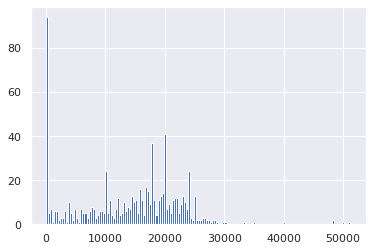

In [201]:
quantity = df[df.Quantity_total<60000]
quantity.Quantity_total.hist(bins=150)

In [39]:
df = df.drop('Unnamed: 0',axis=1)
df.describe()

,Zaaknummer,reason_to_cancel,nr_of_infringements,nr_of_offenders,most_serious_offence,mean_seriousness,class_1_1_explosives_mass,class_1_2_explosives_projection,class_1_3_explosives_fire,class_1_4_explosives_low_risk,class_1_5_explosives_mass_very_insensitive,class_1_6_explosives_very_insensitive,class_2_1_flammable_gases,class_2_2_non_flammable_non_toxic_gases,class_2_3_toxic_gases,class_3_flammable_liquids,class_4_1_flammable_solids,class_4_2_spontaneous_combustion,class_4_3_flammable_gases_in_contact_water,class_5_1_oxidizing_substances,class_5_2_organic_peroxides,class_6_1_toxic_substances,class_6_2_infectious_substances,class_7_radioactive_material,class_8_corrosives,class_9_miscellaneous_dangerous_goods,PG_I_high_danger,PG_II_medium_danger,PG_III_low_danger,class_PG_2_1,class_PG_2_2,class_PG_2_3,class_PG_3_I,class_PG_3_II,class_PG_3_III,class_PG_4_1_I,class_PG_4_1_II,class_PG_4_1_III,class_PG_4_2_I,class_PG_4_2_II,class_PG_4_2_III,class_PG_4_3_I,class_PG_4_3_II,class_PG_4_3_III,class_PG_5_1_I,class_PG_5_1_II,class_PG_5_1_III,class_PG_5_2,class_PG_6_1_I,class_PG_6_1_II,class_PG_6_1_III,class_PG_6_2_I,class_PG_6_2_II,class_PG_6_2_III,class_PG_8,class_PG_8_I,class_PG_8_II,class_PG_8_III,class_PG_9,class_PG_9_I,class_PG_9_II,class_PG_9_III,Quantity_total,Nr_dif_UNNRs,Packaging_DRUM_yn,Packaging_JERRYCAN_yn,Packaging_BOX_yn,Packaging_BAG_yn,Packaging_COMPOSITE_yn,Packaging_UNPACKED_yn,Packaging_IBC_yn,Packaging_LP_yn,Packaging_Bulk_container_yn,Packaging_PR_yn,METAL_packaging_yn,WOODEN_packaging_yn,PLASTIC_packaging_yn,OTHER_packing_material_yn,CONSIGNER_ondoc_yn,CONSIGNEE_ondoc_yn,DATE_ondoc_yn,UNNR_ondoc_yn,PSN_ondoc_yn,CLASS_prim_ondoc_yn,CLASS_sub_ondoc_yn,PG_ondoc_yn,SHIPPERS_decl_ondoc_yn,CPC_yn,QUANTITY_DG_ondoc_yn,EMPTY_UNCLEANED_ondoc_yn,FLASHPOINT_ondoc_yn,WASTES_ondoc_yn,ELEVATED_TEMP_ondoc_yn,LQ_ondoc_yn,Prisma_object_type_corrected_Container,Prisma_object_type_corrected_IMO or UN transport tank,Prisma_in_outgoing_corrected_Incoming,Prisma_in_outgoing_corrected_Outgoing or Transshipment,Prisma_terminal_corrected_APM Terminals Maasvlakte II,Prisma_terminal_corrected_APM Terminals Rotterdam,Prisma_terminal_corrected_ECT Delta Terminal,Prisma_terminal_corrected_Euromax Terminal,Prisma_terminal_corrected_Other terminal,Prisma_terminal_corrected_Rotterdam World Gate Terminal (RWG),Prisma_region_origin_incoming_corrected_Africa,Prisma_region_origin_incoming_corrected_China,Prisma_region_origin_incoming_corrected_India,Prisma_region_origin_incoming_corrected_Latin_America,Prisma_region_origin_incoming_corrected_Middle_East,Prisma_region_origin_incoming_corrected_Rest_of_the_world,Prisma_region_origin_incoming_corrected_South_East_Asia,Prisma_region_destination_incoming_corrected_Europe,Prisma_region_destination_incoming_corrected_Netherlands,Prisma_region_destination_incoming_corrected_Rest_of_the_world,Prisma_cargo_agent_corrected_8 - CMA CGM (Holland) B.V.,Prisma_cargo_agent_corrected_20 - Hapag-Lloyd Rotterdam,Prisma_cargo_agent_corrected_22 - Hyundai Merchant Marine,Prisma_cargo_agent_corrected_24 - Maersk Line,Prisma_cargo_agent_corrected_25 - Mediterranean Shipping Company,Prisma_cargo_agent_corrected_27 - Mueller Liner Agency,Prisma_cargo_agent_corrected_30 - Ocean Network Express (ONE),Prisma_cargo_agent_corrected_Other_cargo_agent
count,750.000000,0.0,750.000000,750.000000,750.000000,750.000000,750.0,750.0,750.0,750.0,750.0,750.0,750.000000,750.000000,750.000000,750.00000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.0,750.000000,750.000000,750.000000,750.00000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.0,750.000000,750.000000,750.000000,750.0,750.0,750.000000,750.000000,750.000000,750.000000,750.0000,750.000000,750.0,750.000000,750.0,750.000000,750.000000,750.000000,750.00000,750.000000,750.0,750.0,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,

### Dropping columns
Taking out offenders as it might be a form of leakage: since everything is good, not that many offenders are added.
Missing lots of outgoing dates which makes it difficult to calculate total spent time in harbours...

In [40]:
#what columns we are taking out for all cases:
cols_to_del = ['Quantity_total','verdict','Zaaknummer','status','short_description','reason_to_cancel','inspector','OTS1','OTS2','OTS3','OTS4','OTS5','OTS6',
              'country','adress','reg_nr_container','container_type','transport_direction','Prisma_registrationcode','Prisma_date_selection','Prisma_method_selection','Prisma_reason_selection',
               'Prisma_incoming_ETA','Prisma_incoming_name_ship','Prisma_outgoing_ETD','Prisma_outgoing_name_ship','Prisma_consigner','Prisma_consignee',
              'offender_1','offender_2','offender_3','offender_4','nr_of_infringements','nr_of_offenders','mean_seriousness']
df = df.drop(cols_to_del,axis=1)

Q: using most_serious_offence instead of verdict since verdict is more the inspectors opinion. Check if there is a difference
Q: check what it means to have 1 as quantity

In [41]:
ondoc_list = list()
class_PG_list = list()
for col in df.columns.tolist():
    #remove all columns which may cause leakage
    if 'ondoc' in col:
        ondoc_list.append(col)
    if 'class_PG' in col:
        class_PG_list.append(col)
        

In [42]:
df = df.drop(class_PG_list+ondoc_list,axis=1)

In [43]:
df.columns.tolist()


['date',
 'most_serious_offence',
 'spec_container_type',
 'transportation_mode',
 'transportation_type',
 'class_1_1_explosives_mass',
 'class_1_2_explosives_projection',
 'class_1_3_explosives_fire',
 'class_1_4_explosives_low_risk',
 'class_1_5_explosives_mass_very_insensitive',
 'class_1_6_explosives_very_insensitive',
 'class_2_1_flammable_gases',
 'class_2_2_non_flammable_non_toxic_gases',
 'class_2_3_toxic_gases',
 'class_3_flammable_liquids',
 'class_4_1_flammable_solids',
 'class_4_2_spontaneous_combustion',
 'class_4_3_flammable_gases_in_contact_water',
 'class_5_1_oxidizing_substances',
 'class_5_2_organic_peroxides',
 'class_6_1_toxic_substances',
 'class_6_2_infectious_substances',
 'class_7_radioactive_material',
 'class_8_corrosives',
 'class_9_miscellaneous_dangerous_goods',
 'PG_I_high_danger',
 'PG_II_medium_danger',
 'PG_III_low_danger',
 'Nr_dif_UNNRs',
 'Packaging_DRUM_yn',
 'Packaging_JERRYCAN_yn',
 'Packaging_BOX_yn',
 'Packaging_BAG_yn',
 'Packaging_COMPOSITE_yn

In [44]:
#counting types of columns and nr of cols
types = list()

for col in df.columns:
    types.append(df[col].dtypes)

    
Counter(types).keys() # equals to list(set(words))
Counter(types).values() # counts the elements' frequency

dict_keys([dtype('O'), dtype('int64'), dtype('float64')])

dict_values([4, 39, 29])

## A bit more feature engineering

In [45]:
#extract the month
df['month'] = pd.to_datetime(df['date'], format='%d-%m-%Y').dt.month
df.drop('date',axis=1,inplace=True)

### Replacing NaNs

In [46]:
nan_list=list()
for col in df.columns.tolist():
    nan_list.append([col,df[col].isnull().values.any(),df[col].dtypes])
nandf = pd.DataFrame(nan_list,columns=['Name','has_nans','dtype'])
nandf[(nandf['has_nans'] == True) & (nandf['dtype'] == 'object')]

,Name,has_nans,dtype
1,spec_container_type,True,object
2,transportation_mode,True,object
3,transportation_type,True,object


In [47]:
#who has NaNs?!
nan_names = nandf[nandf['has_nans'] == True]['Name']
nan_names_list = nan_names.values.tolist()
nan_names_list

['spec_container_type',
 'transportation_mode',
 'transportation_type',
 'CPC_yn',
 'Prisma_object_type_corrected_Container',
 'Prisma_object_type_corrected_IMO or UN transport tank',
 'Prisma_in_outgoing_corrected_Incoming',
 'Prisma_in_outgoing_corrected_Outgoing or Transshipment',
 'Prisma_terminal_corrected_APM Terminals Maasvlakte II',
 'Prisma_terminal_corrected_APM Terminals Rotterdam',
 'Prisma_terminal_corrected_ECT Delta Terminal',
 'Prisma_terminal_corrected_Euromax Terminal',
 'Prisma_terminal_corrected_Other terminal',
 'Prisma_terminal_corrected_Rotterdam World Gate Terminal (RWG)',
 'Prisma_region_origin_incoming_corrected_Africa',
 'Prisma_region_origin_incoming_corrected_China',
 'Prisma_region_origin_incoming_corrected_India',
 'Prisma_region_origin_incoming_corrected_Latin_America',
 'Prisma_region_origin_incoming_corrected_Middle_East',
 'Prisma_region_origin_incoming_corrected_Rest_of_the_world',
 'Prisma_region_origin_incoming_corrected_South_East_Asia',
 'Prisma_

In [48]:
#here to check with Piet on the missing values from the dummied columns
for col in nan_names_list:
    #binary Nans replaced with -1
    if 'yn' in col:
        df[col] = df[col].fillna(-1)
    elif 'corrected' in col:
         df[col] = df[col].fillna(-1)

In [49]:
#filling in other NaNs

more_nans = df[nandf[(nandf['has_nans'] == True) & (nandf['dtype'] == 'object')]['Name']].columns.tolist()
for col in more_nans:
    df[col] = df[col].fillna('missing')
    df[col].unique()

array(['General Purpose Container', 'UN transporttank', 'IMO Tankcontainer', 'missing', 'Bulk Container',
       'Reefer Container', 'UN MEGC'], dtype=object)

array(['Containership', 'missing', 'General Cargo ship', 'Roro', 'RoRo'], dtype=object)

array(['Deep Sea', 'Short Sea', 'missing'], dtype=object)

## Create classes based on verdict

class 1: most serious offence = 2 or 1  
class 0: most serious offence = 0


In [50]:
print('total length of dataframe: ',len(df))
df['target'] = 0
mask = (df['most_serious_offence'] !=0)
#marking class 1 instances
df['target'][mask] = 1

total length of dataframe:  750


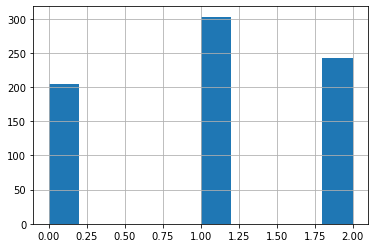

In [51]:
#show the distribution of targets
fig = df.most_serious_offence.hist()
plt.show()

In [52]:
df.drop('most_serious_offence',axis=1,inplace=True)

<AxesSubplot:>

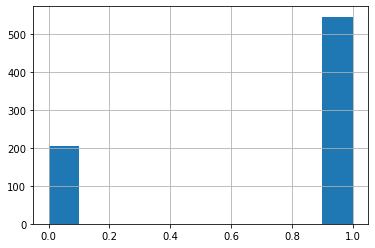

In [53]:
df['target'].hist()

## Dummying

In [54]:
#dummy the object columns
obj_col = df.select_dtypes(['object'])
obj_col

,spec_container_type,transportation_mode,transportation_type
0,General Purpose Container,Containership,Deep Sea
1,UN transporttank,Containership,Deep Sea
2,General Purpose Container,Containership,Deep Sea
3,General Purpose Container,Containership,Deep Sea
4,UN transporttank,Containership,Deep Sea
5,General Purpose Container,Containership,Deep Sea
6,General Purpose Container,Containership,Deep Sea
7,General Purpose Container,Containership,Deep Sea
8,General Purpose Container,Containership,Deep Sea
9,UN transporttank,Containership,Deep Sea


In [55]:
for x in obj_col:
    one_hot = pd.get_dummies(df[x], prefix=x)
    print(one_hot.columns)
    df = pd.concat([df, one_hot],axis=1).drop([x], axis=1)


Index(['spec_container_type_Bulk Container',
       'spec_container_type_General Purpose Container',
       'spec_container_type_IMO Tankcontainer',
       'spec_container_type_Reefer Container', 'spec_container_type_UN MEGC',
       'spec_container_type_UN transporttank', 'spec_container_type_missing'],
      dtype='object')
Index(['transportation_mode_Containership',
       'transportation_mode_General Cargo ship', 'transportation_mode_RoRo',
       'transportation_mode_Roro', 'transportation_mode_missing'],
      dtype='object')
Index(['transportation_type_Deep Sea', 'transportation_type_Short Sea',
       'transportation_type_missing'],
      dtype='object')


In [56]:
#dummy also the month column
one_hot = pd.get_dummies(df['month'], prefix='month')
df = pd.concat([df, one_hot],axis=1).drop(['month'], axis=1)

In [57]:
df.columns.tolist()
len(df.columns.tolist())

['class_1_1_explosives_mass',
 'class_1_2_explosives_projection',
 'class_1_3_explosives_fire',
 'class_1_4_explosives_low_risk',
 'class_1_5_explosives_mass_very_insensitive',
 'class_1_6_explosives_very_insensitive',
 'class_2_1_flammable_gases',
 'class_2_2_non_flammable_non_toxic_gases',
 'class_2_3_toxic_gases',
 'class_3_flammable_liquids',
 'class_4_1_flammable_solids',
 'class_4_2_spontaneous_combustion',
 'class_4_3_flammable_gases_in_contact_water',
 'class_5_1_oxidizing_substances',
 'class_5_2_organic_peroxides',
 'class_6_1_toxic_substances',
 'class_6_2_infectious_substances',
 'class_7_radioactive_material',
 'class_8_corrosives',
 'class_9_miscellaneous_dangerous_goods',
 'PG_I_high_danger',
 'PG_II_medium_danger',
 'PG_III_low_danger',
 'Nr_dif_UNNRs',
 'Packaging_DRUM_yn',
 'Packaging_JERRYCAN_yn',
 'Packaging_BOX_yn',
 'Packaging_BAG_yn',
 'Packaging_COMPOSITE_yn',
 'Packaging_UNPACKED_yn',
 'Packaging_IBC_yn',
 'Packaging_LP_yn',
 'Packaging_Bulk_container_yn',
 'Pa

95

## Find the best model

In [58]:
y = df['target']
df.drop('target',axis=1,inplace=True)


In [59]:
len(df.columns)

94

In [60]:
X = df.copy()

In [61]:
# (not-nested, but simple) cross validation object
inner_cv = StratifiedKFold(n_splits=10, shuffle=True) 

In [62]:
# RF parameter tuning - 
rf_grid = {
    "max_depth"    : [5,10,15,20] #number of max features to be randomly chosen at each split
  , "n_estimators"  : [100,500,1000,1100] 
  , "max_features" : [1.0,
                      math.trunc(round(math.sqrt(len(X.columns)),0)) - 2, 
                      math.trunc(round(math.sqrt(len(X.columns)),0)) +1 ,
                      math.trunc(round(math.sqrt(len(X.columns)),0))- 1,
                      math.trunc(round(math.sqrt(len(X.columns)),0)),
                      math.trunc(round(math.sqrt(len(X.columns)),0)) +2,
                      round(len(X.columns)/2)
                     ]
}
print(rf_grid)

{'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000, 1100], 'max_features': [1.0, 8, 11, 9, 10, 12, 47]}


In [63]:
# RF grid search (combines all possible parameters and gives the parameters for the best cv score)
rf_estimator = GridSearchCV(
    estimator = RandomForestClassifier()
    , param_grid = rf_grid
    , scoring = 'precision'
    , cv = inner_cv
    , n_jobs=-1)

In [64]:
rf_model = rf_estimator.fit(X,y)

In [66]:
import time
print(time.time())

1643286937.6746194


In [67]:
#attribute the best params to the dict
print(' This is the best score of your model: ', rf_model.best_score_)

 This is the best score of your model:  0.7962222756145753


In [68]:
rf_model.best_params_

{'max_depth': 20, 'max_features': 11, 'n_estimators': 100}

In [72]:
best_model = rf_estimator.best_estimator_

### Save the best model

In [69]:
rf_model.best_score_

0.7962222756145753

In [74]:
# Best RF model that was found based on the metric score you specify
best_model = rf_model.best_estimator_
# Save model with the best params
pickle.dump(best_model, open("best_model_GS.pickle","wb"))

<AxesSubplot:xlabel='feature'>

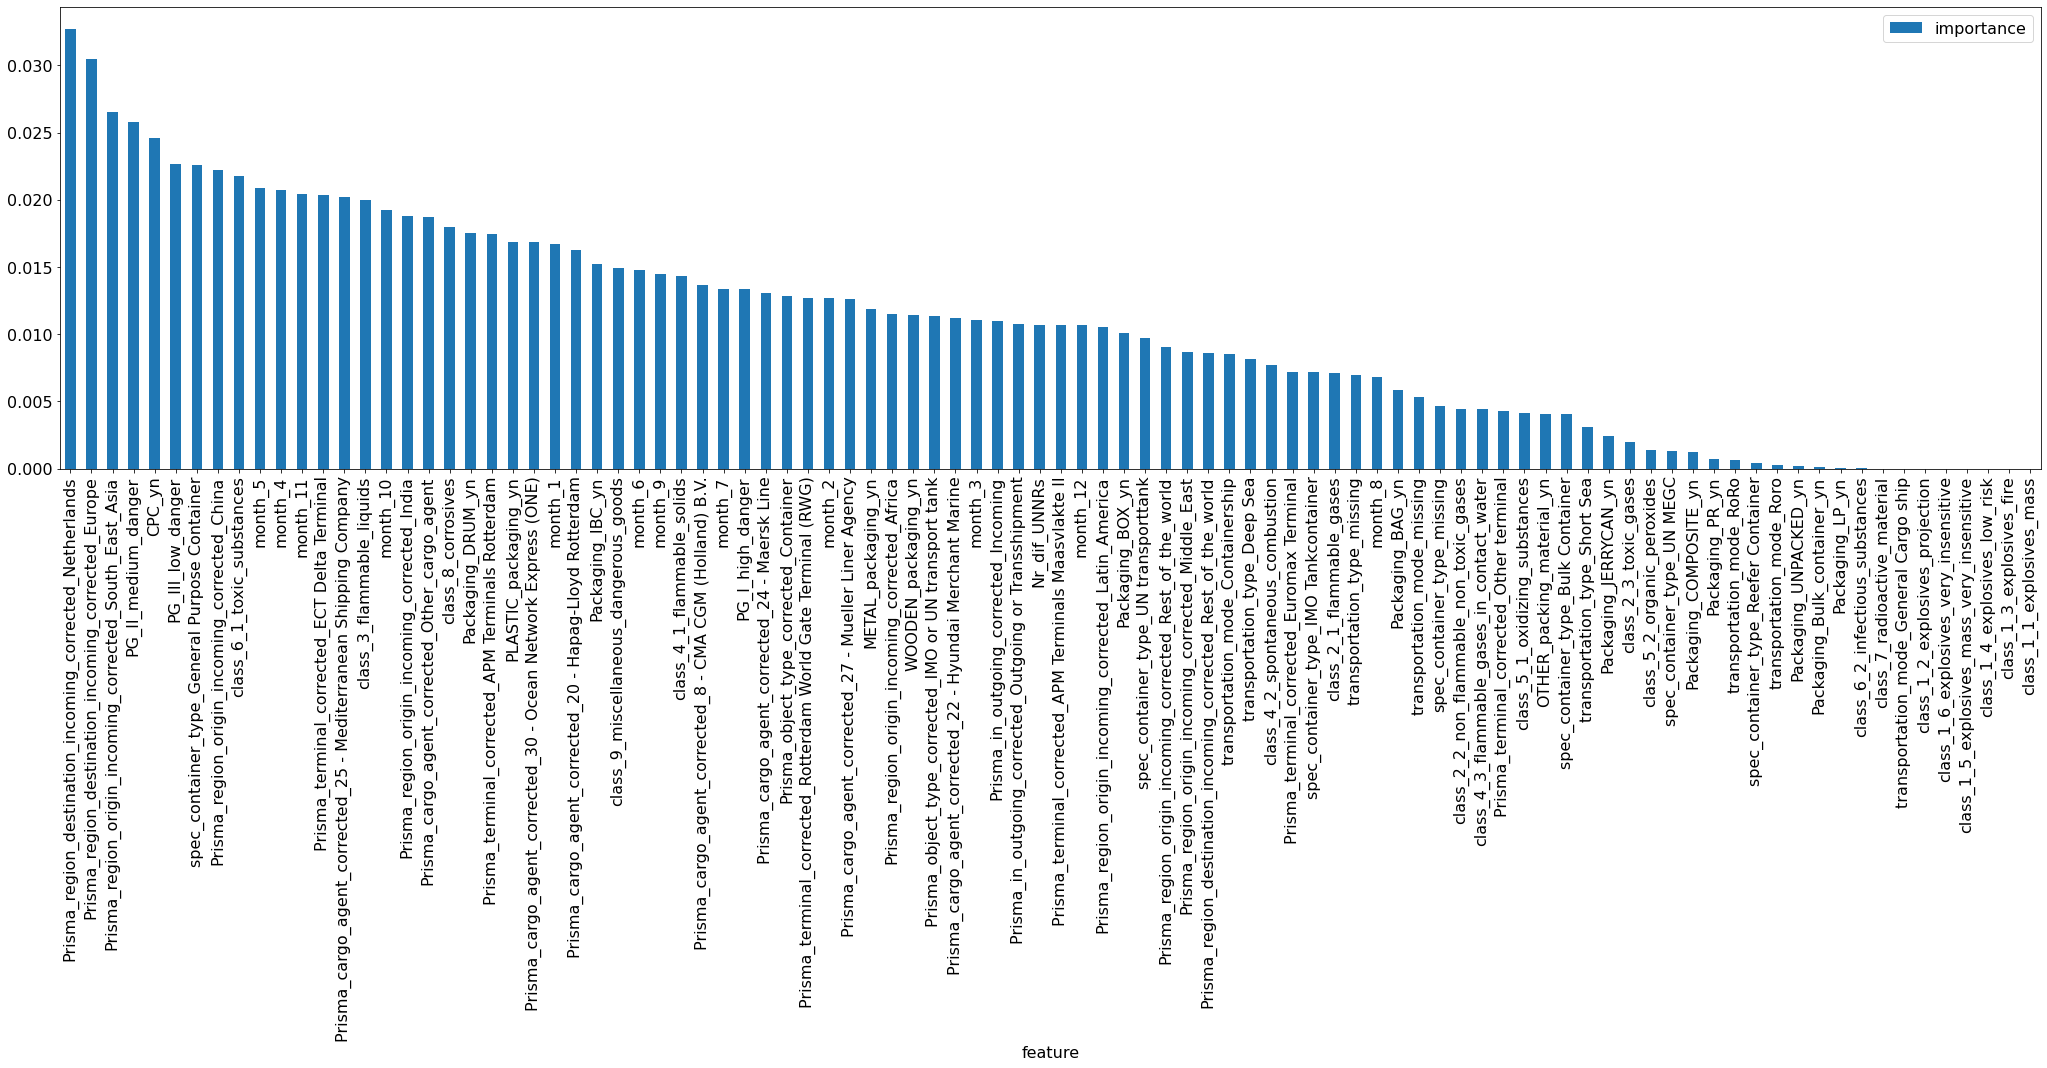

In [99]:
#value importance is useful to understand where the rf makes the most splits

valueImp = pd.DataFrame({"feature": X.columns, "importance": best_model.feature_importances_})
valueImp = valueImp.sort_values(['importance'], ascending=False)
valueImp.set_index('feature',inplace=True)
valueImp.plot(kind='bar',)

fig = plt.gcf()
fig.set_size_inches(35.5, 8.5)
font = {'weight':'normal',
    'size' : 16}
plt.rc('font', **font)
plt.show()

In [82]:
len(X)

750

In [ ]:
#we keep a stratified 5% hidden from the train/test loop for crossval which we use then as a final measure of how good the model is.


## Finding optimal number of features - but does it really matter ?

We have to be careful how we leave columns out, to see if it makes sense in reality. Perhaps entire classes of dangerous goods that are not inspected anyhow? It would not make sense to just leave out specific columns **only** because the precision increases slightly. Also there is a tradeoff between the amount of insights you get and the performance of the model in this case: if you leave all possibly relevant columns in, the performance might drop but the inspectors might get more insights. Or not: since anchors look at the biggest coverages?   What we can find out is whether the ranking of variables changes in various versions of the models and try to understand from there if a variable is important in a specific context or not.

In [150]:
#now we are trying to see with which number of features, the performance of the model grows

inner_cv = StratifiedKFold(n_splits=10, shuffle=True) 
best_nr_dict = {'features_nr':[],
                'features':[],
                'feature_importance':[],
                'best_params':[],
                'score':[],
                'model':[],
                'time_to_fit':[],
                'feature_rank':[]
               }
                
for i in range(0,len(X.columns.tolist())-10):
    #
    columns_to_keep = valueImp.index.tolist()[i:]
    #first choose which columns to keep
    new_X = X[columns_to_keep]
    #standard nr of sqr of columns
    sqr_cols = math.trunc(round(math.sqrt(len(new_X.columns)),0))
    #initialize the grid
    rf_grid = {"max_depth"    : [5,10,15,20] #number of max features to be randomly chosen at each split
              , "n_estimators"  : [100,500,1000] 
              , "max_features" : [1.0, 
                                  sqr_cols - 2, 
                                  sqr_cols - 1 ,
                                  sqr_cols ,
                                  sqr_cols + 1,
                                  sqr_cols + 2,
                                  round(len(new_X.columns)/2)
                     ]
}
    print(i,rf_grid)
    
    # RF grid search (combines all possible parameters and gives the parameters for the best cv score)
    rf_estimator = GridSearchCV(
        estimator = RandomForestClassifier()
        , param_grid = rf_grid
        , scoring = 'precision'
        , cv = inner_cv
        , n_jobs=-1)
    #
    columns_to_keep = valueImp.index.tolist()[i:]
    best_nr_dict['features_nr'].append(len(columns_to_keep))
    best_nr_dict['features'].append(columns_to_keep)
    
    #
    start_time = time.time()
    rf_estimator.fit(X[columns_to_keep],y)
    #
    best_nr_dict['time_to_fit'].append(time.time() - start_time)
    best_nr_dict['score'].append(rf_estimator.best_score_)
    best_nr_dict['model'].append(rf_estimator.best_estimator_)
    best_nr_dict['best_params'].append(rf_estimator.best_params_)
    best_nr_dict['feature_importance'].append(rf_estimator.best_estimator_.feature_importances_)
    
    # retaining the ranks of each feature based on importance
    blind_range = list(range(len(best_nr_dict['feature_importance'][i])))
    my_dict= list(zip(best_nr_dict['feature_importance'][i],blind_range))
    best_nr_dict['feature_rank'].append(my_dict)

0 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 8, 9, 10, 11, 12, 47]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 8, 9, 10, 11, 12, 47],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

1 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 8, 9, 10, 11, 12, 46]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 8, 9, 10, 11, 12, 46],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

2 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 8, 9, 10, 11, 12, 46]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 8, 9, 10, 11, 12, 46],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

3 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 8, 9, 10, 11, 12, 46]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 8, 9, 10, 11, 12, 46],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

4 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 7, 8, 9, 10, 11, 45]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 7, 8, 9, 10, 11, 45],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

5 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 7, 8, 9, 10, 11, 44]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 7, 8, 9, 10, 11, 44],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

6 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 7, 8, 9, 10, 11, 44]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 7, 8, 9, 10, 11, 44],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

7 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 7, 8, 9, 10, 11, 44]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 7, 8, 9, 10, 11, 44],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

8 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 7, 8, 9, 10, 11, 43]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 7, 8, 9, 10, 11, 43],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

9 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 7, 8, 9, 10, 11, 42]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 7, 8, 9, 10, 11, 42],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

10 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 7, 8, 9, 10, 11, 42]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 7, 8, 9, 10, 11, 42],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

11 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 7, 8, 9, 10, 11, 42]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 7, 8, 9, 10, 11, 42],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

12 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 7, 8, 9, 10, 11, 41]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 7, 8, 9, 10, 11, 41],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

13 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 7, 8, 9, 10, 11, 40]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 7, 8, 9, 10, 11, 40],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

14 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 7, 8, 9, 10, 11, 40]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 7, 8, 9, 10, 11, 40],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

15 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 7, 8, 9, 10, 11, 40]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 7, 8, 9, 10, 11, 40],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

16 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 7, 8, 9, 10, 11, 39]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 7, 8, 9, 10, 11, 39],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

17 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 7, 8, 9, 10, 11, 38]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 7, 8, 9, 10, 11, 38],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

18 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 7, 8, 9, 10, 11, 38]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 7, 8, 9, 10, 11, 38],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

19 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 7, 8, 9, 10, 11, 38]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 7, 8, 9, 10, 11, 38],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

20 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 7, 8, 9, 10, 11, 37]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 7, 8, 9, 10, 11, 37],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

21 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 7, 8, 9, 10, 11, 36]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 7, 8, 9, 10, 11, 36],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

22 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 6, 7, 8, 9, 10, 36]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 6, 7, 8, 9, 10, 36],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

23 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 6, 7, 8, 9, 10, 36]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 6, 7, 8, 9, 10, 36],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

24 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 6, 7, 8, 9, 10, 35]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 6, 7, 8, 9, 10, 35],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

25 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 6, 7, 8, 9, 10, 34]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 6, 7, 8, 9, 10, 34],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

26 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 6, 7, 8, 9, 10, 34]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 6, 7, 8, 9, 10, 34],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

27 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 6, 7, 8, 9, 10, 34]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 6, 7, 8, 9, 10, 34],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

28 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 6, 7, 8, 9, 10, 33]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 6, 7, 8, 9, 10, 33],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

29 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 6, 7, 8, 9, 10, 32]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 6, 7, 8, 9, 10, 32],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

30 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 6, 7, 8, 9, 10, 32]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 6, 7, 8, 9, 10, 32],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

31 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 6, 7, 8, 9, 10, 32]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 6, 7, 8, 9, 10, 32],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

32 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 6, 7, 8, 9, 10, 31]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 6, 7, 8, 9, 10, 31],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

33 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 6, 7, 8, 9, 10, 30]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 6, 7, 8, 9, 10, 30],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

34 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 6, 7, 8, 9, 10, 30]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 6, 7, 8, 9, 10, 30],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

35 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 6, 7, 8, 9, 10, 30]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 6, 7, 8, 9, 10, 30],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

36 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 6, 7, 8, 9, 10, 29]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 6, 7, 8, 9, 10, 29],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

37 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 6, 7, 8, 9, 10, 28]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 6, 7, 8, 9, 10, 28],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

38 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 5, 6, 7, 8, 9, 28]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 5, 6, 7, 8, 9, 28],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

39 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 5, 6, 7, 8, 9, 28]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 5, 6, 7, 8, 9, 28],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

40 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 5, 6, 7, 8, 9, 27]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 5, 6, 7, 8, 9, 27],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

41 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 5, 6, 7, 8, 9, 26]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 5, 6, 7, 8, 9, 26],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

42 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 5, 6, 7, 8, 9, 26]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 5, 6, 7, 8, 9, 26],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

43 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 5, 6, 7, 8, 9, 26]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 5, 6, 7, 8, 9, 26],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

44 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 5, 6, 7, 8, 9, 25]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 5, 6, 7, 8, 9, 25],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

45 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 5, 6, 7, 8, 9, 24]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 5, 6, 7, 8, 9, 24],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

46 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 5, 6, 7, 8, 9, 24]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 5, 6, 7, 8, 9, 24],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

47 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 5, 6, 7, 8, 9, 24]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 5, 6, 7, 8, 9, 24],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

48 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 5, 6, 7, 8, 9, 23]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 5, 6, 7, 8, 9, 23],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

49 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 5, 6, 7, 8, 9, 22]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 5, 6, 7, 8, 9, 22],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

50 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 5, 6, 7, 8, 9, 22]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 5, 6, 7, 8, 9, 22],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

51 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 5, 6, 7, 8, 9, 22]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 5, 6, 7, 8, 9, 22],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

52 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 4, 5, 6, 7, 8, 21]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 4, 5, 6, 7, 8, 21],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

53 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 4, 5, 6, 7, 8, 20]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 4, 5, 6, 7, 8, 20],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

54 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 4, 5, 6, 7, 8, 20]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 4, 5, 6, 7, 8, 20],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

55 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 4, 5, 6, 7, 8, 20]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 4, 5, 6, 7, 8, 20],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

56 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 4, 5, 6, 7, 8, 19]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 4, 5, 6, 7, 8, 19],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

57 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 4, 5, 6, 7, 8, 18]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 4, 5, 6, 7, 8, 18],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

58 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 4, 5, 6, 7, 8, 18]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 4, 5, 6, 7, 8, 18],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

59 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 4, 5, 6, 7, 8, 18]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 4, 5, 6, 7, 8, 18],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

60 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 4, 5, 6, 7, 8, 17]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 4, 5, 6, 7, 8, 17],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

61 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 4, 5, 6, 7, 8, 16]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 4, 5, 6, 7, 8, 16],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

62 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 4, 5, 6, 7, 8, 16]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 4, 5, 6, 7, 8, 16],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

63 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 4, 5, 6, 7, 8, 16]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 4, 5, 6, 7, 8, 16],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

64 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 3, 4, 5, 6, 7, 15]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 3, 4, 5, 6, 7, 15],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

65 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 3, 4, 5, 6, 7, 14]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 3, 4, 5, 6, 7, 14],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

66 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 3, 4, 5, 6, 7, 14]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 3, 4, 5, 6, 7, 14],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

67 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 3, 4, 5, 6, 7, 14]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 3, 4, 5, 6, 7, 14],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

68 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 3, 4, 5, 6, 7, 13]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 3, 4, 5, 6, 7, 13],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

69 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 3, 4, 5, 6, 7, 12]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 3, 4, 5, 6, 7, 12],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

70 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 3, 4, 5, 6, 7, 12]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 3, 4, 5, 6, 7, 12],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

71 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 3, 4, 5, 6, 7, 12]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 3, 4, 5, 6, 7, 12],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

72 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 3, 4, 5, 6, 7, 11]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 3, 4, 5, 6, 7, 11],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

73 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 3, 4, 5, 6, 7, 10]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 3, 4, 5, 6, 7, 10],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

74 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 2, 3, 4, 5, 6, 10]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 2, 3, 4, 5, 6, 10],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

75 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 2, 3, 4, 5, 6, 10]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 2, 3, 4, 5, 6, 10],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

76 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 2, 3, 4, 5, 6, 9]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 2, 3, 4, 5, 6, 9],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

77 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 2, 3, 4, 5, 6, 8]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 2, 3, 4, 5, 6, 8],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

78 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 2, 3, 4, 5, 6, 8]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 2, 3, 4, 5, 6, 8],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

79 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 2, 3, 4, 5, 6, 8]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 2, 3, 4, 5, 6, 8],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

80 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 2, 3, 4, 5, 6, 7]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 2, 3, 4, 5, 6, 7],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

81 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 2, 3, 4, 5, 6, 6]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 2, 3, 4, 5, 6, 6],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

82 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 1, 2, 3, 4, 5, 6]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 1, 2, 3, 4, 5, 6],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

83 {'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000], 'max_features': [1.0, 1, 2, 3, 4, 5, 6]}


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [1.0, 1, 2, 3, 4, 5, 6],
                         'n_estimators': [100, 500, 1000]},
             scoring='precision')

In [181]:
#save for later use
# with open('feature_optim_dict.pickle', "wb") as f:
#     pickle.dump(best_nr_dict, f)
    

In [104]:
features_importance_rank = pd.DataFrame(index=X.columns)

In [122]:
ranks_all = best_nr_dict['features']
for x in range(0,len(ranks_all))

x = best_nr_dict['features'][i]
range= list(zip(x,ranks))

In [138]:
dict(res)

{'Prisma_region_destination_incoming_corrected_Netherlands': 0,
 'Prisma_region_destination_incoming_corrected_Europe': 1,
 'Prisma_region_origin_incoming_corrected_South_East_Asia': 2,
 'PG_II_medium_danger': 3,
 'CPC_yn': 4,
 'PG_III_low_danger': 5,
 'spec_container_type_General Purpose Container': 6,
 'Prisma_region_origin_incoming_corrected_China': 7,
 'class_6_1_toxic_substances': 8,
 'month_5': 9,
 'month_4': 10,
 'month_11': 11,
 'Prisma_terminal_corrected_ECT Delta Terminal': 12,
 'Prisma_cargo_agent_corrected_25 - Mediterranean Shipping Company': 13,
 'class_3_flammable_liquids': 14,
 'month_10': 15,
 'Prisma_region_origin_incoming_corrected_India': 16,
 'Prisma_cargo_agent_corrected_Other_cargo_agent': 17,
 'class_8_corrosives': 18,
 'Packaging_DRUM_yn': 19,
 'Prisma_terminal_corrected_APM Terminals Rotterdam': 20,
 'PLASTIC_packaging_yn': 21,
 'Prisma_cargo_agent_corrected_30 - Ocean Network Express (ONE)': 22,
 'month_1': 23,
 'Prisma_cargo_agent_corrected_20 - Hapag-Lloyd 

In [139]:
d = pd.Series(dict(res))

In [141]:
features_importance_rank['1'] = d

In [143]:
features_importance_rank

,1
class_1_1_explosives_mass,93
class_1_2_explosives_projection,88
class_1_3_explosives_fire,92
class_1_4_explosives_low_risk,91
class_1_5_explosives_mass_very_insensitive,90
class_1_6_explosives_very_insensitive,89
class_2_1_flammable_gases,60
class_2_2_non_flammable_non_toxic_gases,66
class_2_3_toxic_gases,74
class_3_flammable_liquids,14


In [178]:
{key:best_nr_dict[key][:25] for key in best_nr_dict.keys()}

{'features_nr': [94,
  93,
  92,
  91,
  90,
  89,
  88,
  87,
  86,
  85,
  84,
  83,
  82,
  81,
  80,
  79,
  78,
  77,
  76,
  75,
  74,
  73,
  72,
  71,
  70],
 'features': [['Prisma_region_destination_incoming_corrected_Netherlands',
   'Prisma_region_destination_incoming_corrected_Europe',
   'Prisma_region_origin_incoming_corrected_South_East_Asia',
   'PG_II_medium_danger',
   'CPC_yn',
   'PG_III_low_danger',
   'spec_container_type_General Purpose Container',
   'Prisma_region_origin_incoming_corrected_China',
   'class_6_1_toxic_substances',
   'month_5',
   'month_4',
   'month_11',
   'Prisma_terminal_corrected_ECT Delta Terminal',
   'Prisma_cargo_agent_corrected_25 - Mediterranean Shipping Company',
   'class_3_flammable_liquids',
   'month_10',
   'Prisma_region_origin_incoming_corrected_India',
   'Prisma_cargo_agent_corrected_Other_cargo_agent',
   'class_8_corrosives',
   'Packaging_DRUM_yn',
   'Prisma_terminal_corrected_APM Terminals Rotterdam',
   'PLASTIC_packa

<AxesSubplot:xlabel='features_nr', ylabel='score'>

TypeError: unhashable type: 'slice'

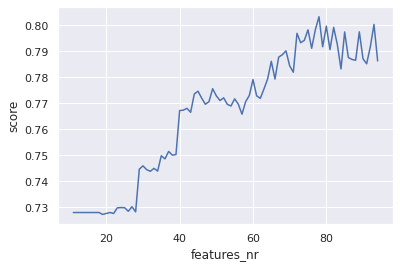

In [172]:
#performance (precision) of best set of params given the same gridsearch
sns.lineplot(data=best_nr_dict, x="features_nr", y="score")

zoom_in = best_nr_dict[0:25]
sns.lineplot(data=zoom_in, x="features_nr", y="score")


In [189]:
best_score = max(best_nr_dict['score'])

In [190]:
if best_nr_dict['score']==best_score:
    print(best_nr_dict.values())

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Model Performance

### Dashboard specific model performance 

We do a manual nested cross validation to use the csv for the explainer dashboard. We keep the grid search with the cross val and add another external loop. The nested CV optimizes the search for the best hyperparams across multiple dataset splits: we may get different *optimal hyperparams* for different splits, with varying performance. Therefore we average over the performance of different optimal hyperparams for different splits and get a more realistic average performance, and the standard deviation which gives you an indication of possible overfitting.

In [ ]:
# RF grid search (combines all possible parameters and gives the parameters for the best cv score)
rf_estimator = GridSearchCV(
    estimator = RandomForestClassifier()
    , param_grid = rf_grid
    , scoring = 'precision'
    , cv = inner_cv
    , n_jobs=-1)

In [77]:
best_model

RandomForestClassifier(max_depth=20, max_features=10, n_estimators=1500)

In [35]:
#we add the label, predicted score and fold to lists and then save it to a csv
rs = 42
labels = list()
predictions = list()
fold = list()
i = 0

#stratified folds with manual fold retain
StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
     
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #fit the grid and retain the best model
    rf_estimator.fit(X_train,y_train)
    best_model = rf_estimator.best_estimator_
    
    #use the best model to get only predicted class 1 scores
    probs = rf_estimator.predict_proba(X_test)[:,1]
    
    #retain ground truth labels,predictions and fold numbers
    labels.append(y_test.tolist())
    predictions.append(probs)
    fold.append([i]*len(probs))
    
    #keep random state per fold
    rs = rs+1
    #show progress
    print(i)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [10, 12, 6, 8, 10],
                         'n_estimators': [500, 1000, 1300, 1500]},
             scoring='precision')

0


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [10, 12, 6, 8, 10],
                         'n_estimators': [500, 1000, 1300, 1500]},
             scoring='precision')

1


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [10, 12, 6, 8, 10],
                         'n_estimators': [500, 1000, 1300, 1500]},
             scoring='precision')

2


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [10, 12, 6, 8, 10],
                         'n_estimators': [500, 1000, 1300, 1500]},
             scoring='precision')

3


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [10, 12, 6, 8, 10],
                         'n_estimators': [500, 1000, 1300, 1500]},
             scoring='precision')

4


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [10, 12, 6, 8, 10],
                         'n_estimators': [500, 1000, 1300, 1500]},
             scoring='precision')

5


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [10, 12, 6, 8, 10],
                         'n_estimators': [500, 1000, 1300, 1500]},
             scoring='precision')

6


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [10, 12, 6, 8, 10],
                         'n_estimators': [500, 1000, 1300, 1500]},
             scoring='precision')

7


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [10, 12, 6, 8, 10],
                         'n_estimators': [500, 1000, 1300, 1500]},
             scoring='precision')

9


In [49]:
len(labels[1])

75

In [42]:
#flattening
labels_flat   = [val for sublist in labels for val in sublist]
predictions_flat   = [val for sublist in predictions for val in sublist]
fold_flat   = [val for sublist in fold for val in sublist]

In [47]:
dev_dict = {'labels':labels_flat,
           'predictions':predictions_flat,
           'fold':fold_flat}
dev_set = pd.DataFrame.from_dict(dev_dict)


750

In [51]:
dev_set.to_csv('dev_set_GS_zeevaart.csv',index=False)

### Notebook-specific model performance

In [69]:
#print(date.datetime.now())
# Nested CV with parameter optimization
outer_cv = StratifiedKFold(n_splits=10, shuffle=True)
scoring = ('precision', 'recall', 'average_precision', 'roc_auc')
nested_score = cross_validate(rf_estimator, X=X, y=y, scoring = scoring ,cv=outer_cv)

In [75]:
mean_test_roc_auc = nested_score['test_roc_auc'].mean()
mean_test_roc_auc 

mean_test_precision = nested_score['test_precision'].mean()
mean_test_precision

mean_test_recall = nested_score['test_recall'].mean()
mean_test_recall

mean_test_average_precision = nested_score['test_average_precision'].mean()
mean_test_average_precision

0.7208298861632195

0.7886925941027434

0.9322222222222223

0.8551846215344743